<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

### Importing Packages

In [8]:
import os
import time
from packaging import version
import pandas as pd
import numpy as np

import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from textblob import Word
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Mount Google Drive to Colab Environment

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS453/Assignment 3/')
path_to_file='ClassCorpus_v4.csv'

<div class="alert alert-block alert-info">
    <b>Spacy </b><br>
    https://spacy.io/usage/models
    </div>

In [10]:
nlp = spacy.load('en_core_web_sm')

### Functions

In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Create Knowledge Graphs

### Load and Preprocess Data

In [ ]:
data = pd.read_csv(path_to_file)
data = data[data['Student Name'] == 'VXL']
corpusJoined = ' '.join([x for x in data['Text']]).split('.') #split at periods and then add it to corpus

In [ ]:
corpusJoined[:5]

['Marvel really kicked it into high gear with their new release Guardians of the Galaxy',
 ' I am not a huge Marvel comic book reader (DC Fan here), so I glean what I can from Wikipedia and friends who read the comics (mostly Sam, my co-editor) but I do follow the cinematic universe pretty closely',
 ' Marvel has repeatedly done well with their movies, despite the hiccup I would call Iron Man 2, each film has been better than the last and Guardians is no exception',
 '\nRight off of the success of Captain America 2: Winter Soldier comes Guardians with another wonderful ensemble cast and a story unlike any we’ve previously seen',
 ' I have to hand it to Marvel for being able to make what might look like just a rag tag group of law breakers into heroes right before our eyes']

In [ ]:
# function to preprocess speech
def clean(text):
    
    # removing new line characters
    text = re.sub('\n',' ',str(text))

    return text

In [ ]:
# clean text
data['processed_text'] = data['Text'].apply(clean)
corpusJoined = ' '.join([x for x in data['processed_text']]).split('.') 

In [ ]:
corpusJoined[:5]

['Marvel really kicked it into high gear with their new release Guardians of the Galaxy',
 ' I am not a huge Marvel comic book reader (DC Fan here), so I glean what I can from Wikipedia and friends who read the comics (mostly Sam, my co-editor) but I do follow the cinematic universe pretty closely',
 ' Marvel has repeatedly done well with their movies, despite the hiccup I would call Iron Man 2, each film has been better than the last and Guardians is no exception',
 ' Right off of the success of Captain America 2: Winter Soldier comes Guardians with another wonderful ensemble cast and a story unlike any we’ve previously seen',
 ' I have to hand it to Marvel for being able to make what might look like just a rag tag group of law breakers into heroes right before our eyes']

### Function Entity Extraction

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

### Entity Pair Extraction from Corpus

In [ ]:
entity_pairs = []

for i in tqdm(corpusJoined):
  entity_pairs.append(get_entities(i))

100%|██████████| 317/317 [00:04<00:00, 74.52it/s]


In [ ]:
entity_pairs[-20:]

[['morning razzle that', 'George Lucas'],
 ['Chris Pratt', 'much Harrison Guardians'],
 ['comic Peter Quill', 'hero'],
 ['then A list I', 'sonic  screwdriver'],
 ['when  he', 'immediately  mother'],
 ['alien rogue Yondu', ''],
 ['later  Peter', 'iconic Cherry Feeling'],
 ['Peter', 'now bounty that'],
 ['evil Lee who', 'golem'],
 ['eventually  you', 'guardians  galaxy'],
 ['They', 'monosyllabic Bradley Cooper'],
 ['Together  they', 'intergalactic A heroes'],
 ['You', 'picture'],
 ['Inevitably  Guardians', 'daring screen death'],
 ['It', 'jokey manner jokey conventional'],
 ['strong  cast', 'apparently Prime Nova'],
 ['you', 'close  scrutiny'],
 ['end Guardians', 'Galaxy'],
 ['I', 'forward  it'],
 ['', '']]

### Function Get Relation

In [ ]:
def get_relation(sent):
    try:
        doc = nlp(sent)
        # Matcher class object 
        matcher = Matcher(nlp.vocab)
        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        return(span.text)
    except:
        pass

In [ ]:
relations = []
for i in corpusJoined:
    relations.append(get_relation(i))

In [ ]:
print(pd.Series(relations).value_counts()[:30])

is                      61
are                     14
has                     11
’s                       9
's                       6
feel                     4
get                      4
know                     4
it                       3
want                     3
takes                    2
saving                   2
’m                       2
becomes                  2
was                      2
had                      2
am                       2
set                      2
provides                 2
There                    2
find                     2
starts                   2
have                     2
Stifle                   1
going                    1
begins                   1
form                     1
stop                     1
interactions between     1
From                     1
dtype: int64


### Extract Subject and Object

In [ ]:
#extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
kg_df.head(40)

,source,target,edge
0,Marvel,new Galaxy,kicked
1,mostly I,cinematic universe,glean
2,Guardians,last,done
3,ensemble we,ensemble any,comes
4,what,right law eyes,have
5,bipedal talking that,bipedal talking gem,take
6,it,hilarious Marvel date,is
7,way you,Guardians,is
8,new aka Star who,thief,Lord
9,when he,little galaxy,He


### Create a Directed-graph from Dataframe

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

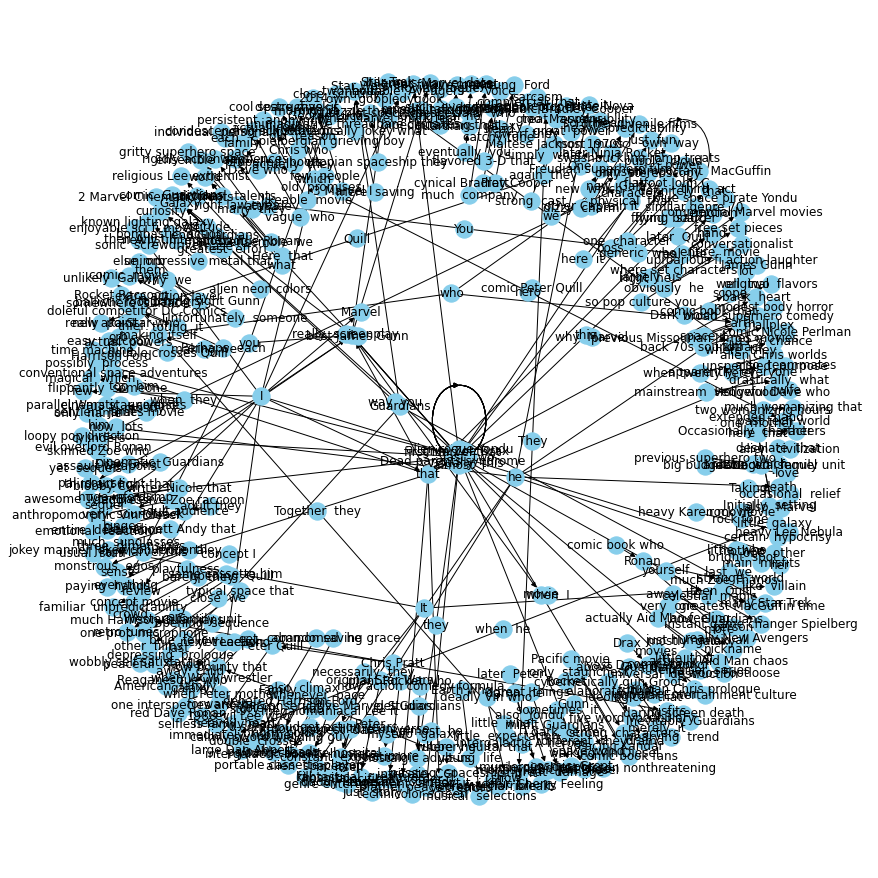

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

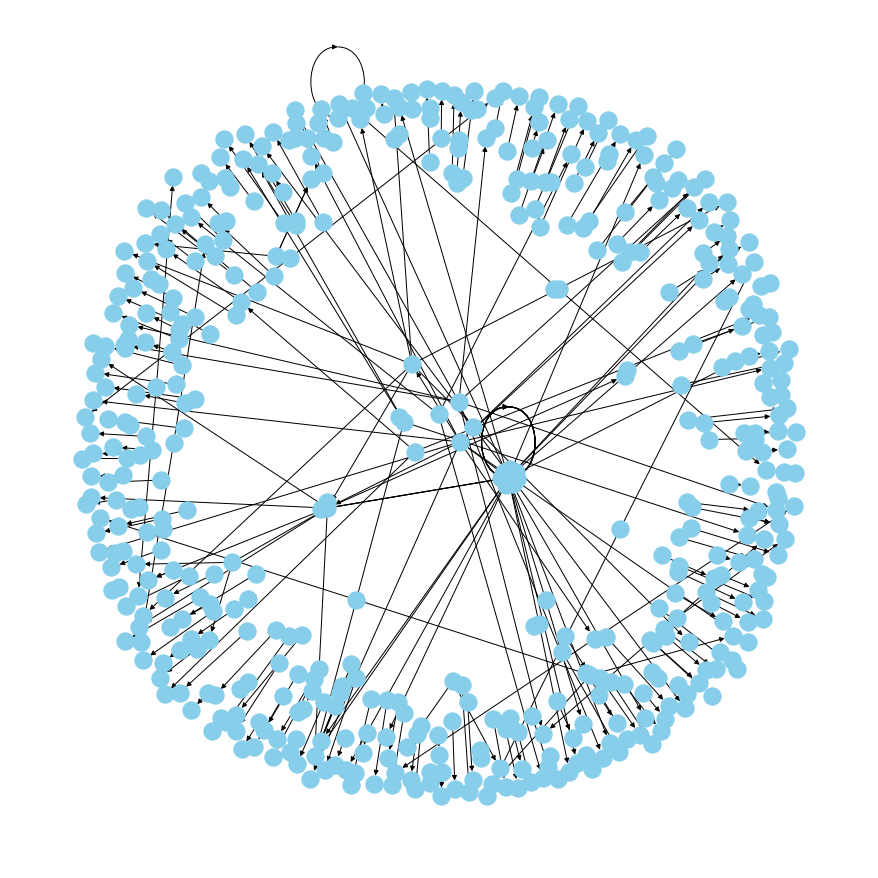

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=False, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Plot Directed-graph - Subset of Nodes and Edges

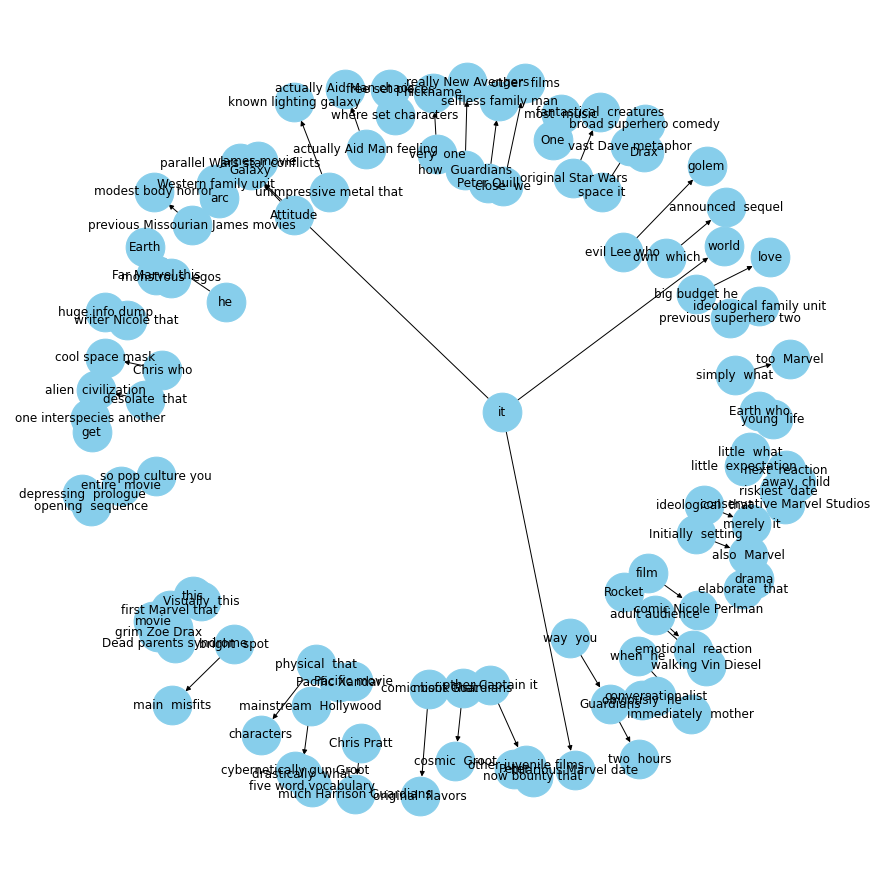

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

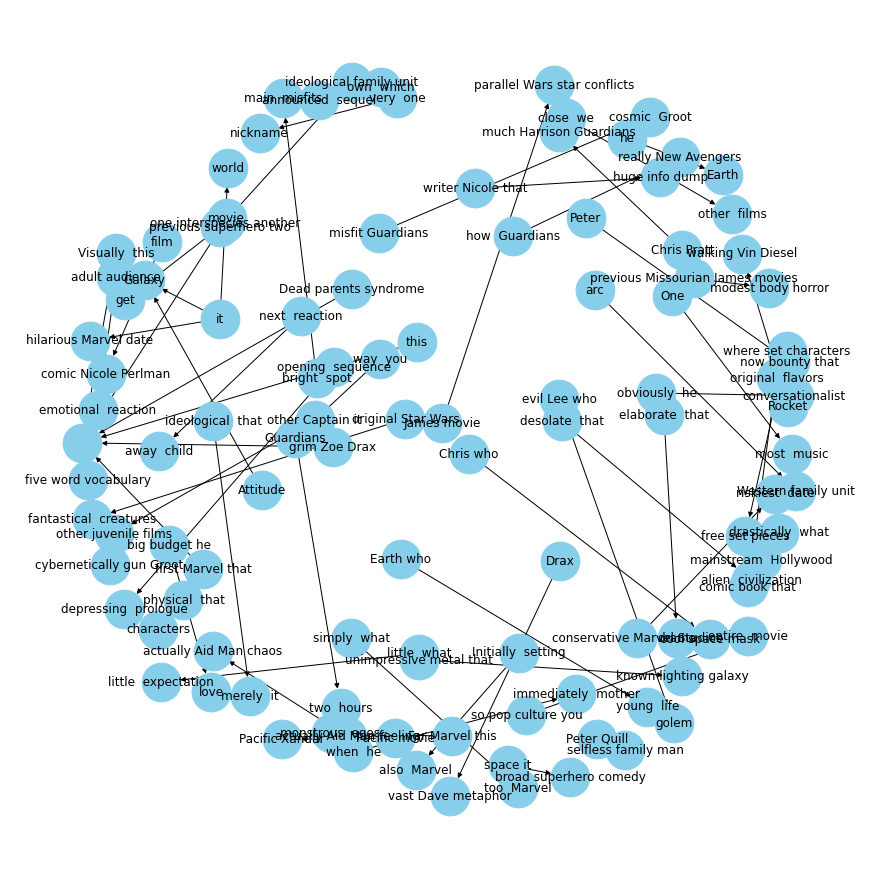

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

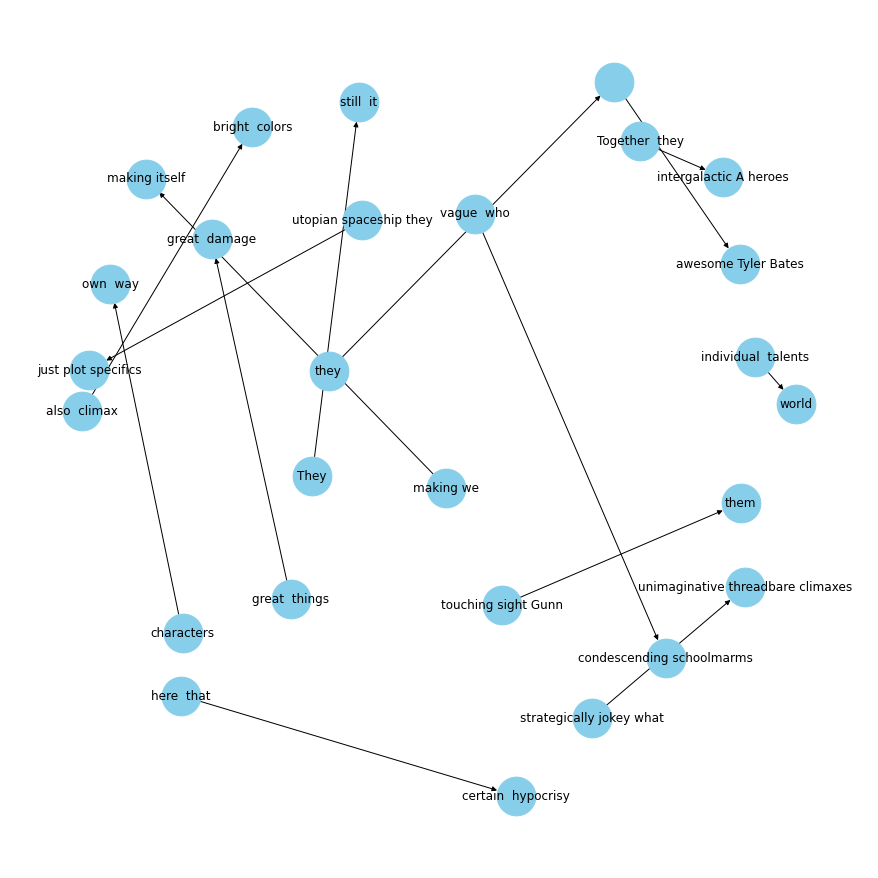

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="are"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

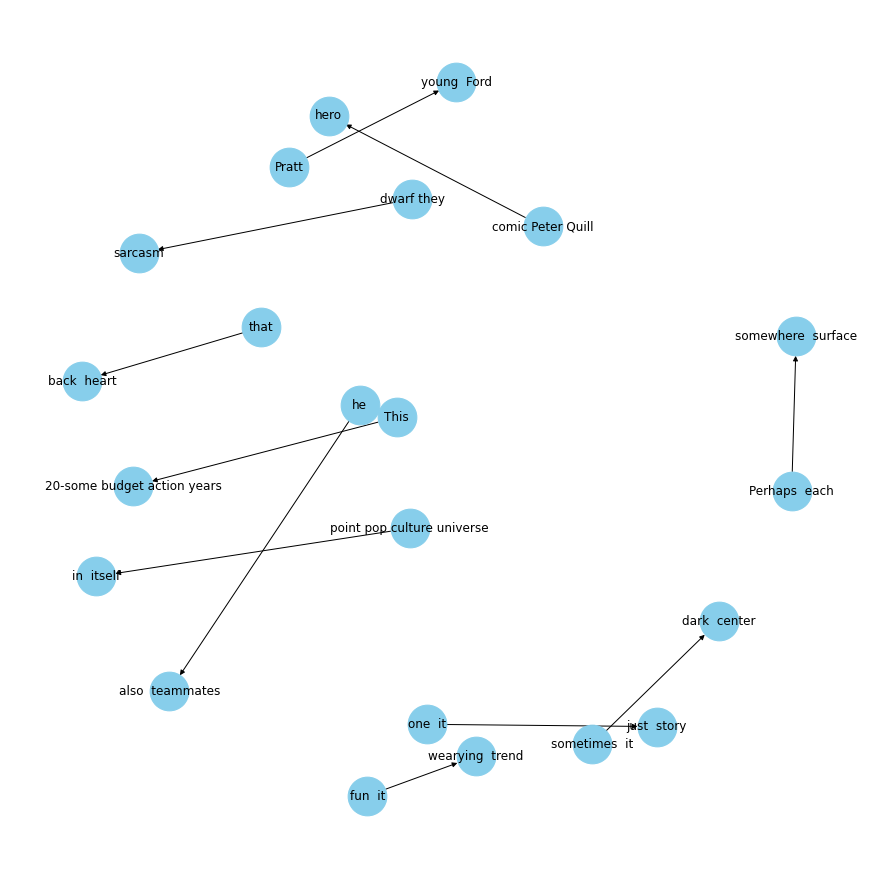

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="has"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.8) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df_lower = kg_df.applymap(lambda s: s.lower())
kg_df_lower.head()

,source,target,edge
0,marvel,new galaxy,kicked
1,mostly i,cinematic universe,glean
2,guardians,last,done
3,ensemble we,ensemble any,comes
4,what,right law eyes,have


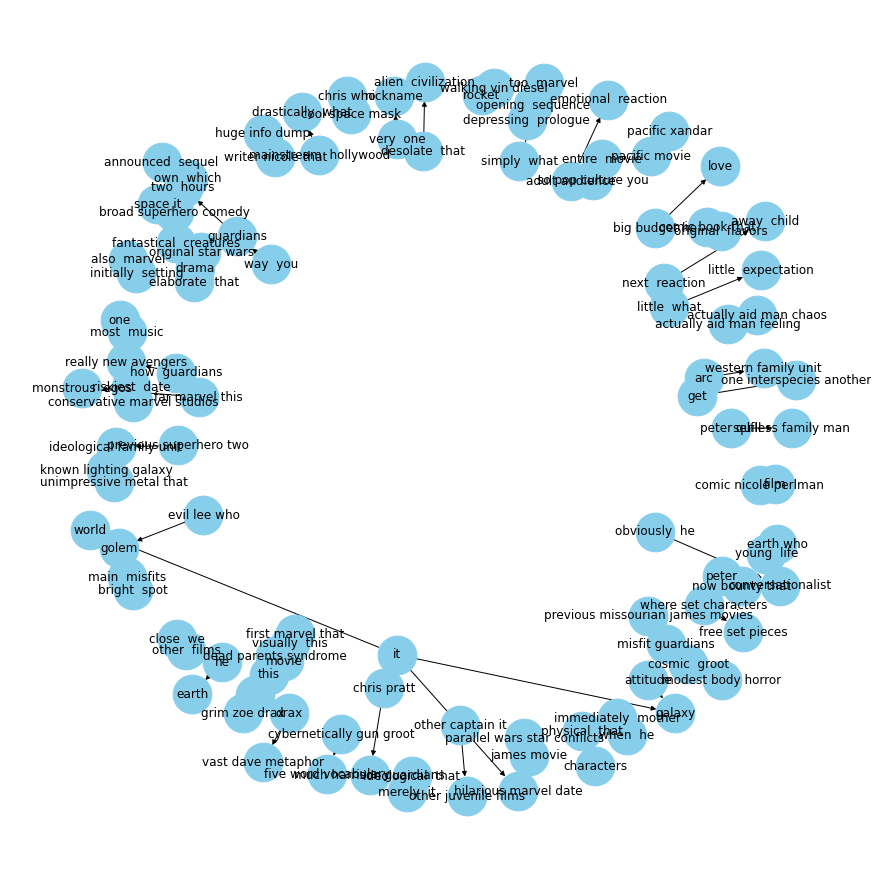

In [ ]:
G=nx.from_pandas_edgelist(kg_df_lower[kg_df_lower['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

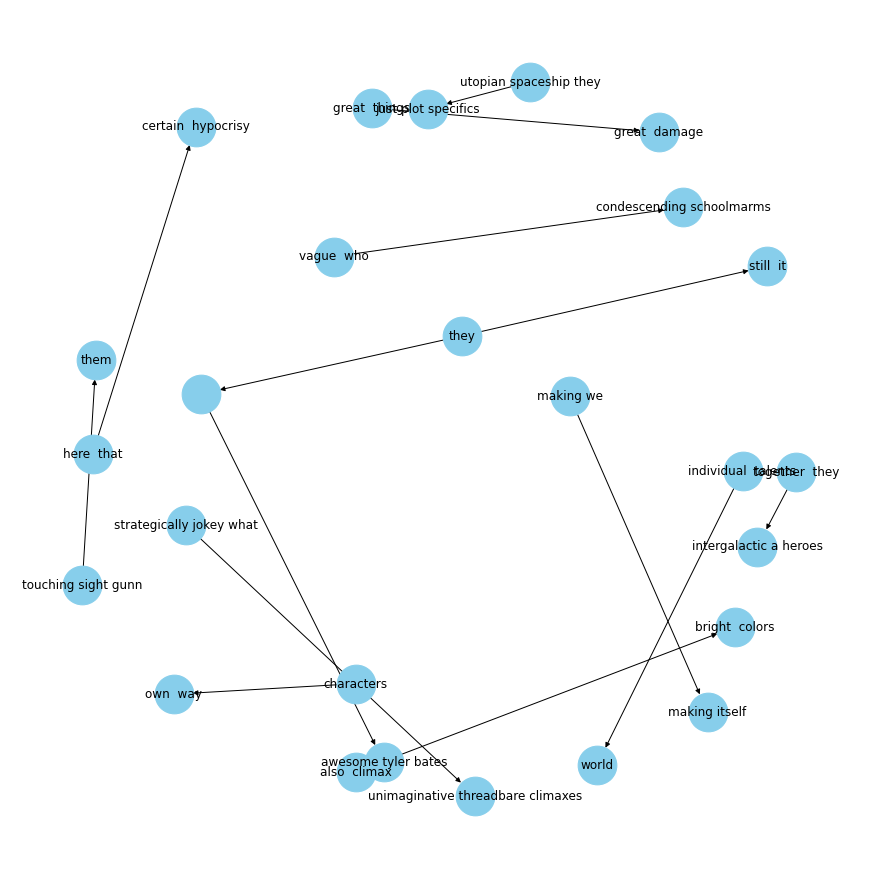

In [ ]:
G=nx.from_pandas_edgelist(kg_df_lower[kg_df_lower['edge']=="are"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df_subset = kg_df_lower[kg_df_lower['edge'].isin(["are", "is", "has"])]
kg_df_subset.head()

,source,target,edge
6,it,hilarious marvel date,is
7,way you,guardians,is
16,how guardians,really new avengers,is
18,they,still it,are
19,,awesome tyler bates,are


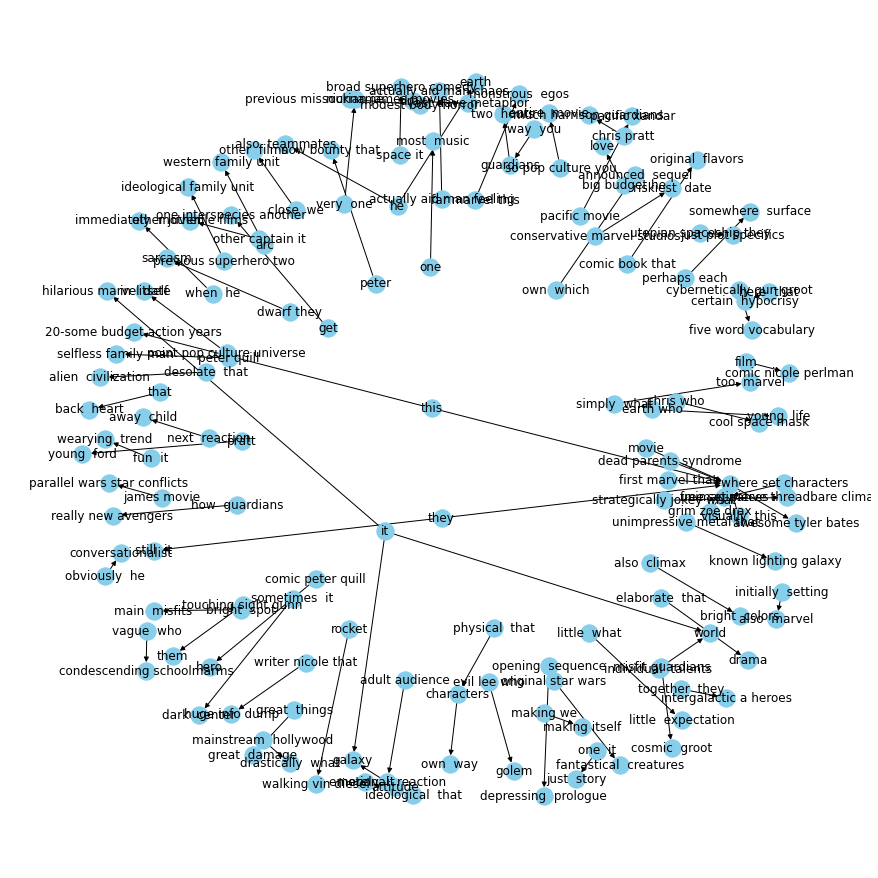

In [ ]:
G=nx.from_pandas_edgelist(kg_df_subset, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.2)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Classification Model using LSTM

<font size="2"> Santhosh , K. T. (2021, June). NLP: Sentiment Analysis Using LSTM. Analytics Vidhya. Retrieved 2022, from https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/ </font>

### Load and Create Training, Validation, and Testing Sets


In [5]:
data = pd.read_csv(path_to_file)

In [10]:
def cleaning(df, stop_words, column):

    df[column] = df[column].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the special characters
    df[column] = df[column].str.replace('[^ws]', '')
    # Replacing the digits/numbers
    df[column] = df[column].str.replace('d', '')
    # Removing stop words
    df[column] = df[column].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df[column] = df[column].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')
data_v1 = cleaning(data, stop_words, 'Text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [11]:
tokenizer = Tokenizer(num_words=2000, split=' ') 
tokenizer.fit_on_texts(data_v1['Text'].values)
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X)

In [12]:
#Splitting the data into training and testing
y = pd.get_dummies(data_v1['Review Type (pos or neg)']) #one hot encode the sentiments
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((168, 1), (168, 2), (43, 1), (43, 2), (38, 1), (38, 2))

In [14]:
y_train.value_counts(ascending=True)

Negative  Positive
0         1           84
1         0           84
dtype: int64

There are 84 positive and 84 negative reviews in the training set.

### Experiment 1

#### Create the Model

In [15]:
model = Sequential()
model.add(tf.keras.layers.Embedding(2000, 10, mask_zero=True, input_length = X.shape[1]))
model.add(tf.keras.layers.LSTM(15))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             20000     
                                                                 
 lstm (LSTM)                 (None, 15)                1560      
                                                                 
 dense (Dense)               (None, 10)                160       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 21,742
Trainable params: 21,742
Non-trainable params: 0
_________________________________________________________________
None


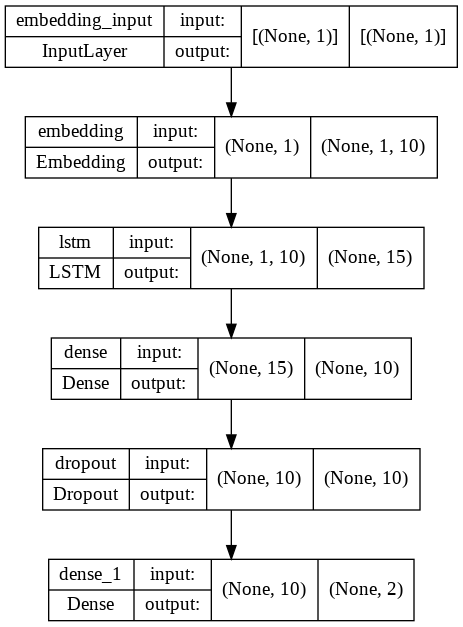

In [17]:
keras.utils.plot_model(model, "SingleLayerBiDirectionalLSTM.png", show_shapes=True)

#### Compile Model

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True]


#### Train the Model

In [20]:
start = time.time()

history = model.fit(X_train, y_train
                    ,epochs=20
                    ,validation_data=(X_val, y_val)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
6/6 [==============================] - 7s 321ms/step - loss: 0.6937 - accuracy: 0.4881 - val_loss: 0.6934 - val_accuracy: 0.3721
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5655 - val_loss: 0.6930 - val_accuracy: 0.4419
Epoch 3/20
6/6 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.6310 - val_loss: 0.6931 - val_accuracy: 0.4651
Epoch 4/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.5893 - val_loss: 0.6939 - val_accuracy: 0.4651
Epoch 5/20
6/6 [==============================] - 0s 9ms/step - loss: 0.6891 - accuracy: 0.6190 - val_loss: 0.6941 - val_accuracy: 0.4651
Total time:  7.693492889404297 seconds


In [21]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2/2 [==============================] - 0s 9ms/step - loss: 0.6918 - accuracy: 0.5789
Test Loss: 0.6917527914047241
Test Accuracy: 0.5789473652839661


#### Plotting Performance Metrics 

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

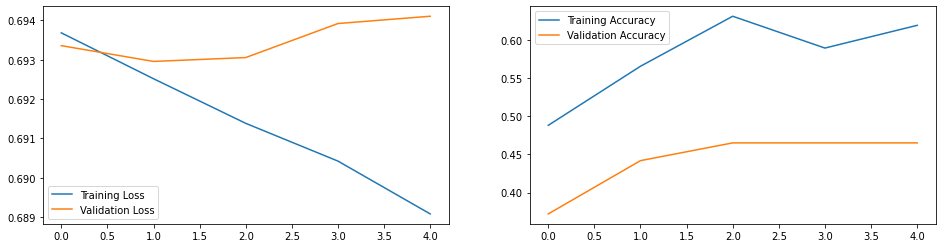

In [24]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Experiment 2

#### Create the Model

In [133]:
model = Sequential()
model.add(tf.keras.layers.Embedding(2000, 10, mask_zero=True, input_length = X.shape[1]))
model.add(tf.keras.layers.LSTM(5))
model.add(tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [134]:
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 1, 10)             20000     
                                                                 
 lstm_12 (LSTM)              (None, 5)                 320       
                                                                 
 dense_21 (Dense)            (None, 5)                 30        
                                                                 
 dropout_4 (Dropout)         (None, 5)                 0         
                                                                 
 dense_22 (Dense)            (None, 2)                 12        
                                                                 
Total params: 20,362
Trainable params: 20,362
Non-trainable params: 0
_________________________________________________________________
None


#### Compile Model

In [135]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [136]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True]


#### Train the Model

In [137]:
start = time.time()

history = model.fit(X_train, y_train
                    ,epochs=20
                    ,validation_data=(X_val, y_val)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
6/6 [==============================] - 6s 298ms/step - loss: 0.6972 - accuracy: 0.4940 - val_loss: 0.6974 - val_accuracy: 0.4419
Epoch 2/20
6/6 [==============================] - 0s 8ms/step - loss: 0.6962 - accuracy: 0.5238 - val_loss: 0.6970 - val_accuracy: 0.5581
Epoch 3/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.5595 - val_loss: 0.6972 - val_accuracy: 0.4419
Epoch 4/20
6/6 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.6369 - val_loss: 0.6976 - val_accuracy: 0.3953
Total time:  5.901442766189575 seconds


In [138]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2/2 [==============================] - 0s 5ms/step - loss: 0.6974 - accuracy: 0.4211
Test Loss: 0.6973598599433899
Test Accuracy: 0.42105263471603394


#### Plotting Performance Metrics 

In [139]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [140]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

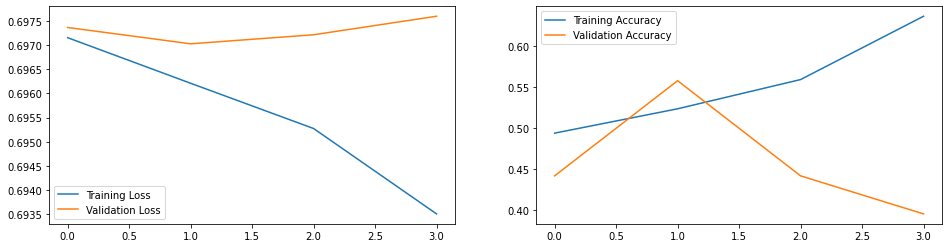

In [141]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Experiment 3

#### Create the Model

In [142]:
model = Sequential()
model.add(tf.keras.layers.Embedding(2000, 10, mask_zero=True, input_length = X.shape[1]))
model.add(tf.keras.layers.LSTM(1))
model.add(tf.keras.layers.Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [143]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 1, 10)             20000     
                                                                 
 lstm_13 (LSTM)              (None, 1)                 48        
                                                                 
 dense_23 (Dense)            (None, 2)                 4         
                                                                 
 dropout_5 (Dropout)         (None, 2)                 0         
                                                                 
 dense_24 (Dense)            (None, 2)                 6         
                                                                 
Total params: 20,058
Trainable params: 20,058
Non-trainable params: 0
_________________________________________________________________
None


#### Compile Model

In [144]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [145]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True]


#### Train the Model

In [146]:
start = time.time()

history = model.fit(X_train, y_train
                    ,epochs=20
                    ,validation_data=(X_val, y_val)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
6/6 [==============================] - 6s 308ms/step - loss: 0.6945 - accuracy: 0.4524 - val_loss: 0.6951 - val_accuracy: 0.4186
Epoch 2/20
6/6 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.4186
Epoch 3/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6933 - accuracy: 0.5119 - val_loss: 0.6947 - val_accuracy: 0.4186
Total time:  5.82822847366333 seconds


In [147]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2/2 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.6316
Test Loss: 0.6944869160652161
Test Accuracy: 0.6315789222717285


#### Plotting Performance Metrics 

In [148]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [149]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

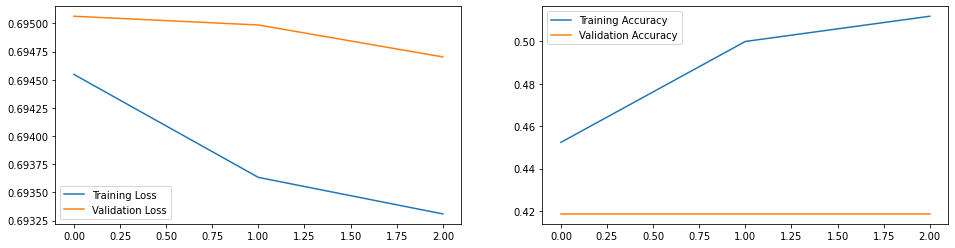

In [150]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Experiment 4

#### Create the Model

In [163]:
model = Sequential()
model.add(tf.keras.layers.Embedding(2000, 10, mask_zero=True, input_length = X.shape[1]))
model.add(tf.keras.layers.LSTM(1))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [164]:
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 1, 10)             20000     
                                                                 
 lstm_16 (LSTM)              (None, 1)                 48        
                                                                 
 dropout_10 (Dropout)        (None, 1)                 0         
                                                                 
 dense_29 (Dense)            (None, 2)                 4         
                                                                 
 dropout_11 (Dropout)        (None, 2)                 0         
                                                                 
 dense_30 (Dense)            (None, 2)                 6         
                                                                 
Total params: 20,058
Trainable params: 20,058
Non-tra

#### Compile Model

In [165]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [166]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True, True]


#### Train the Model

In [167]:
start = time.time()

history = model.fit(X_train, y_train
                    ,epochs=20
                    ,validation_data=(X_val, y_val)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
6/6 [==============================] - 7s 298ms/step - loss: 0.6939 - accuracy: 0.4762 - val_loss: 0.6938 - val_accuracy: 0.5581
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.5536 - val_loss: 0.6938 - val_accuracy: 0.5581
Epoch 3/20
6/6 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5179 - val_loss: 0.6939 - val_accuracy: 0.5116
Total time:  6.842045307159424 seconds


In [168]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2/2 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4474
Test Loss: 0.6947109699249268
Test Accuracy: 0.44736841320991516


#### Plotting Performance Metrics 

In [169]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [170]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

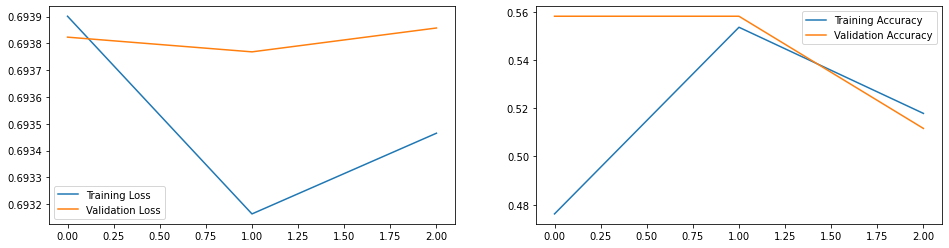

In [171]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Experiment 5

#### Create the Model

In [172]:
model = Sequential()
model.add(tf.keras.layers.Embedding(2000, 10, mask_zero=True, input_length = X.shape[1]))
model.add(tf.keras.layers.Bidirectional(LSTM(1)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [173]:
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 1, 10)             20000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 2)                96        
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 2)                 0         
                                                                 
 dense_31 (Dense)            (None, 2)                 6         
                                                                 
 dropout_13 (Dropout)        (None, 2)                 0         
                                                                 
 dense_32 (Dense)            (None, 2)                 6         
                                                     

#### Compile Model

In [174]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [175]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True, True]


#### Train the Model

In [176]:
start = time.time()

history = model.fit(X_train, y_train
                    ,epochs=20
                    ,validation_data=(X_val, y_val)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
6/6 [==============================] - 13s 1s/step - loss: 0.6956 - accuracy: 0.5714 - val_loss: 0.6962 - val_accuracy: 0.5349
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.6942 - accuracy: 0.5536 - val_loss: 0.6967 - val_accuracy: 0.4651
Epoch 3/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6954 - accuracy: 0.5417 - val_loss: 0.6968 - val_accuracy: 0.4651
Total time:  13.03571629524231 seconds


In [177]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2/2 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.5789
Test Loss: 0.6946403980255127
Test Accuracy: 0.5789473652839661


#### Plotting Performance Metrics 

In [178]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [179]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

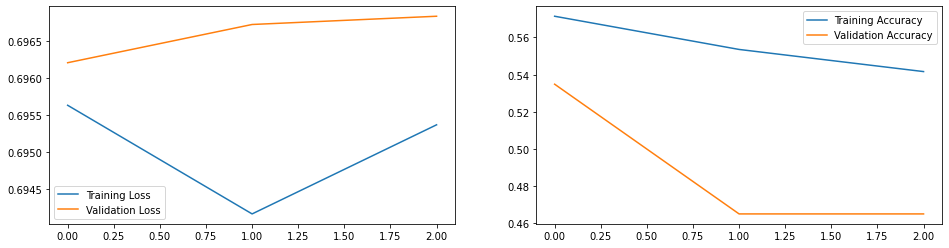

In [180]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Experiment 6

#### Create the Model

In [213]:
model = Sequential()
model.add(tf.keras.layers.Embedding(2000, 10, mask_zero=True, input_length = X.shape[1]))
model.add(tf.keras.layers.Bidirectional(LSTM(2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [214]:
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 1, 10)             20000     
                                                                 
 bidirectional_11 (Bidirecti  (None, 4)                208       
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 4)                 0         
                                                                 
 dense_39 (Dense)            (None, 4)                 20        
                                                                 
 dropout_23 (Dropout)        (None, 4)                 0         
                                                                 
 dense_40 (Dense)            (None, 2)                 10        
                                                     

#### Compile Model

In [215]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [216]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True, True, True]


#### Train the Model

In [217]:
start = time.time()

history = model.fit(X_train, y_train
                    ,epochs=20
                    ,validation_data=(X_val, y_val)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
6/6 [==============================] - 11s 575ms/step - loss: 0.6956 - accuracy: 0.4643 - val_loss: 0.6954 - val_accuracy: 0.4419
Epoch 2/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.5298 - val_loss: 0.6954 - val_accuracy: 0.4186
Epoch 3/20
6/6 [==============================] - 0s 9ms/step - loss: 0.6952 - accuracy: 0.5536 - val_loss: 0.6951 - val_accuracy: 0.5814
Epoch 4/20
6/6 [==============================] - 0s 11ms/step - loss: 0.6951 - accuracy: 0.5119 - val_loss: 0.6950 - val_accuracy: 0.5814
Epoch 5/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6950 - accuracy: 0.5060 - val_loss: 0.6947 - val_accuracy: 0.5814
Total time:  11.250155925750732 seconds


In [218]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2/2 [==============================] - 0s 9ms/step - loss: 0.6957 - accuracy: 0.3947
Test Loss: 0.6957082152366638
Test Accuracy: 0.3947368562221527


#### Plotting Performance Metrics 

In [219]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [220]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

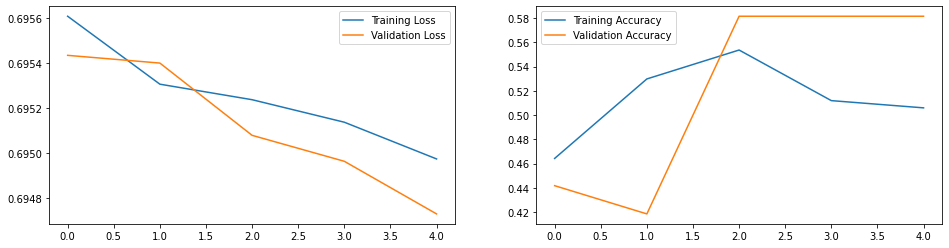

In [221]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()